In [174]:
from torchvision import transforms #add this line in the above snippet
from torch.utils.data import DataLoader #add this line in the above snippet
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from caltech256 import Caltech256
from torchvision.utils import make_grid
import torch.nn.functional as F
import utils
import my_nn

ImportError: No module named my_nn

In [114]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))ß
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(12, 4))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.01)  # pause a bit so that plots are updated

In [115]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = datasets.CIFAR10(root='data/CIFAR10', train=False, download=True, transform=transform_test)
X_size = 2000
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(np.random.choice(np.arange(10000),
                                                                              X_size, replace=False))

dataloaders = {
    'train': torch.utils.data.DataLoader(testset, batch_size=1, num_workers=1),
    'valid': torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=8)
}


Files already downloaded and verified


In [ ]:
train_data = dataloaders['train']

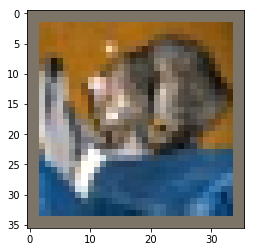

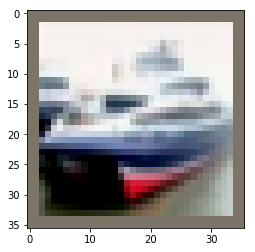

In [195]:
train_data = dataloaders['train']
data_iter = iter(train_data)
data_1, label_1 = next(data_iter)
data_2, label1_2 = next(data_iter)

out_origin_1 = torchvision.utils.make_grid(data_1)
imshow(out_origin_1)
out_origin_2 = torchvision.utils.make_grid(data_2)
imshow(out_origin_2)

In [196]:
##visualization for vgg16
vgg16_model_conv = torchvision.models.vgg16(pretrained=True)
class Modified_VGG16_plot(nn.Module):
    def __init__(self, layer_number):
        super(Modified_VGG16_plot, self).__init__()
        self.features = nn.Sequential(
            # stop at block4
            *list(vgg16_model_conv.features.children())[:layer_number]
        )

    def forward(self, x):
        x = self.features(x)
        return x
model_vgg16 = Modified_VGG16_plot(5)

torch.Size([1, 64, 16, 16])


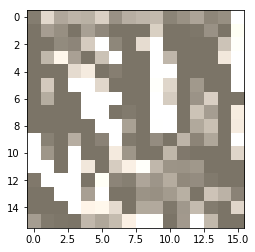

In [203]:
data_vgg16_1 = model_vgg16.forward(Variable(data_1)).data
print(data_vgg16_1.shape)
out_vgg16_1 = torchvision.utils.make_grid(data_vgg16_1[0][0])
imshow(out_vgg16_1)

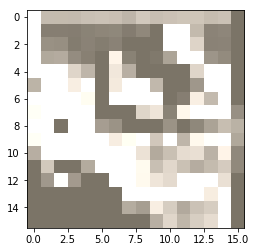

In [199]:
data_vgg16_2 = model_vgg16.forward(Variable(data_2)).data
out_vgg16_2 = torchvision.utils.make_grid(data_vgg16_2[0][0])
imshow(out_vgg16_2)

In [213]:
diff = data_vgg16_1 - data_vgg16_2
data_vgg16_1_flaten = data_vgg16_1.view(1,-1).numpy()
data_vgg16_2_flaten = data_vgg16_2.view(1,-1).numpy()
result = np.sum(data_vgg16_1_flaten * data_vgg16_2_flaten, axis = 1) / (np.linalg.norm(data_vgg16_1_flaten) * np.linalg.norm(data_vgg16_1_flaten))
inter = data_vgg16_1_flaten * data_vgg16_2_flaten
print(inter.shape)
print(result)

(1, 16384)
[0.36950514]


In [122]:
use_cuda = torch.cuda.is_available()
class LenNet(nn.Module):
    '''Restaurant at the end of the universe.'''
    def __init__(self, weight_init=None):
        nn.Module.__init__(self)
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # init
        if weight_init=='xavier':
            for module in self.modules():
                if isinstance(module, nn.Conv2d):
                    n = module.kernel_size[0] * module.kernel_size[1] * module.out_channels
                    module.weight.data.normal_(0, math.sqrt(2. / n))
                elif isinstance(module, nn.BatchNorm2d):
                    module.weight.data.fill_(1)
                    module.bias.data.zero_()

    def forward(self, x):
        #x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16*5*5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
        return x





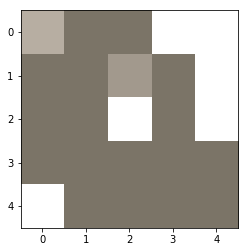

In [123]:
net = LenNet()

net.load_state_dict(torch.load('../uap/pretrained-networks/LenNet-5.pkl'))

data_lenet = net.forward((Variable(data)).cpu()).data
out_lenet = torchvision.utils.make_grid(data_lenet[0][0])
imshow(out_lenet)

In [176]:
class ResBlock(nn.Module):
    '''Block for ResNet.
    
    As many layers for ResNet share the same kernel size and number of channels, we design this module.
    Typically, there are 2 conv layers for each block.
    '''
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.residual = nn.Sequential()
        if stride!=1 or in_channels!=out_channels:
            self.residual = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                        nn.BatchNorm2d(out_channels),
                    )

    def forward(self, x):
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        output += self.residual(x)
        output = F.relu(output)
        return output

    """
    def __init__(self, in_channels, out_channels, is_top_block=False):
        '''If it's the first block of layer:
            - we use a stride of 2 for the first conv layer of this block
            - double in_channels
            Otherwise:
            - stride = 1
            - in_channels = out_channels
        '''
        super(ResBlock, self).__init__()
        self.is_top_block = is_top_block
        if is_top_block:
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)
            # double number of channels
            self.downsample = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, 1, stride=2, padding=0, bias=False),
                        #nn.BatchNorm2d(out_channels),
                    ) 
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            self.downsample = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.conv2(y)
        #print('Y shape: ')
        #print(y.data.numpy().shape)
        if self.downsample:
            x = self.downsample(x)
            #print('X shape: ')
            #print(x.data.numpy().shape)
        y += x
        y = self.bn2(y)
        return F.relu(y)
    """

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride,] + [1,] * (num_blocks-1)
        res_layer = []
        for stride in strides:
            res_layer.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*res_layer)

    def forward(self, x):
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = F.avg_pool2d(output, 4)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output

def ResNet18():
    return ResNet(ResBlock, [2,2,2,2])

In [178]:
resnet = ResNet18()

In [186]:
resnet.load_state_dict(torch.load('./ResNet18-32p-93.pkl'))
print(resnet)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (layer1): Sequential (
    (0): ResBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (residual): Sequential (
      )
    )
    (1): ResBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (residual): Sequential (
      )
    )
  )
  (layer2): Sequential (
    (0): ResBloc

In [184]:
class Modified_RES18_plot(nn.Module):
    def __init__(self,layer_number):
        super(Modified_RES18_plot, self).__init__()
        self.features = nn.Sequential(
            # stop at block4
            *list(resnet.children())[:layer_number]
        )

    def forward(self, x):
        x = self.features(x)
        return x

In [189]:
model_res18 = Modified_RES18_plot(6)
print(model_res18)

Modified_RES18_plot (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): Sequential (
      (0): ResBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (residual): Sequential (
        )
      )
      (1): ResBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (residual): Sequentia

torch.Size([1, 512, 4, 4])


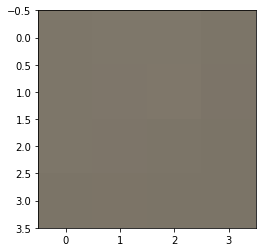

In [190]:
model_res18 = Modified_RES18_plot(6)
data_res18 = model_res18.forward(Variable(data)).data
print(data_res18.shape)
out_res18 = torchvision.utils.make_grid(data_res18[0][0])

imshow(out_res18)

In [129]:
data_resnet18 = res18_model_conv.forward((Variable(data))).data

RuntimeError: Given input size: (512x1x1). Calculated output size: (512x0x0). Output size is too small at /opt/conda/conda-bld/pytorch_1503966894950/work/torch/lib/THNN/generic/SpatialAveragePooling.c:64